In [2]:
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import vice
import sys
sys.path.append("../")
from vice_utils import calculate_z, sample_stars, filter_stars, show_stars, R_to_zone, zone_to_R, show_at_R_z
import apogee_analysis as aah
from plotting import fig_saver
import model_comparer


/home/daniel/surp/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [4]:
sf = fig_saver("figures")

In [5]:
def load_model(name):
    """Loads a vice.milkyway model output at the location name
    
    Parameters
    ----------
    name : str
        the name of the model to load
    
    Returns
    -------
    vice.multioutput file
    """
    milkyway = vice.output(name)
    milkyway.stars["abs_z"] = calculate_z(milkyway)
    milkyway.stars["R_origin"] = zone_to_R(np.array(milkyway.stars["zone_origin"]))
    milkyway.stars["R_final"] = zone_to_R(np.array(milkyway.stars["zone_final"]))
    if "[c/o]" not in milkyway.stars.keys():
        milkyway.stars["[c/o]"] = -np.array(milkyway.stars["[o/c]"]) 
    if "[c/n]" not in milkyway.stars.keys():
        milkyway.stars["[c/n]"] = -np.array(milkyway.stars["[n/c]"])
    return milkyway

In [11]:
models = {}
for name in ["output/cristallo11"]:
    models[name] = load_model(name)

In [12]:
# sample the stars from each model to show accurate representations
# of the stellar populations
max_zone = 155
stars = {}
solar_neighborhood_stars = {}
for name, model in models.items():
    # remove numerical artifacts
    s = model.stars.filter("zone_origin", "<", max_zone)
    stars[name] = sample_stars(s, num=10_000)
    solar_neighborhood_stars[name] = sample_stars(filter_stars(s, 7, 9, 0, 0.5), num=10_000)

<ipython-input-10-26f55450bba7>:3: RuntimeWarning: invalid value encountered in log10
  cn_h = np.log10((
<ipython-input-10-26f55450bba7>:3: RuntimeWarning: invalid value encountered in log10
  cn_h = np.log10((


Text(0, 0.5, '[c+n/o]')

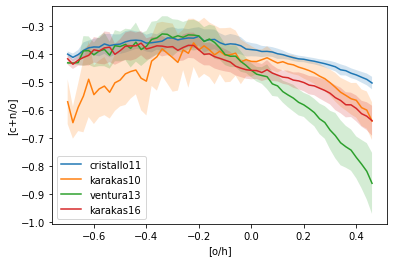

In [10]:
for name, s in stars.items():

    cn_h = np.log10((
        aah.bracket_to_abundance(s["[c/h]"], "C") -
        aah.bracket_to_abundance(s["[n/h]"], "N"))
        / (vice.solar_z("C") - vice.solar_z("N")))
    s["[cn/h]"] = cn_h
    s["[cn/o]"] = cn_h - s["[o/h]"]
    # plt.scatter(s["[o/h]"], cn_h)
    bins = np.arange(-0.7, 0.5, 0.02)
    y, yerr= model_comparer.means_star_value(s, "[cn/o]", "[o/h]", bins)
    plt.plot(bins[:-1], y, label=name)
    plt.fill_between(bins[:-1], y-yerr, y+yerr, alpha=0.2)

plt.legend()
plt.xlabel("[o/h]")
plt.ylabel("[c+n/o]")

(array([1.000e+00, 0.000e+00, 2.000e+00, 7.000e+00, 2.000e+01, 8.900e+01,
        5.660e+02, 2.318e+03, 5.222e+03, 1.775e+03]),
 array([-2.70361483, -2.3555558 , -2.00749677, -1.65943774, -1.31137871,
        -0.96331968, -0.61526065, -0.26720162,  0.08085741,  0.42891644,
         0.77697547]),
 <BarContainer object of 10 artists>)

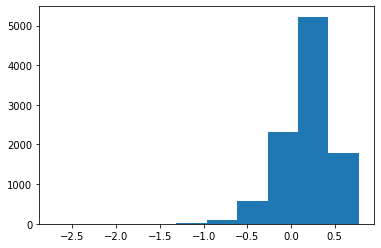

In [19]:
plt.hist(stars["cristallo11"]["[o/h]"])

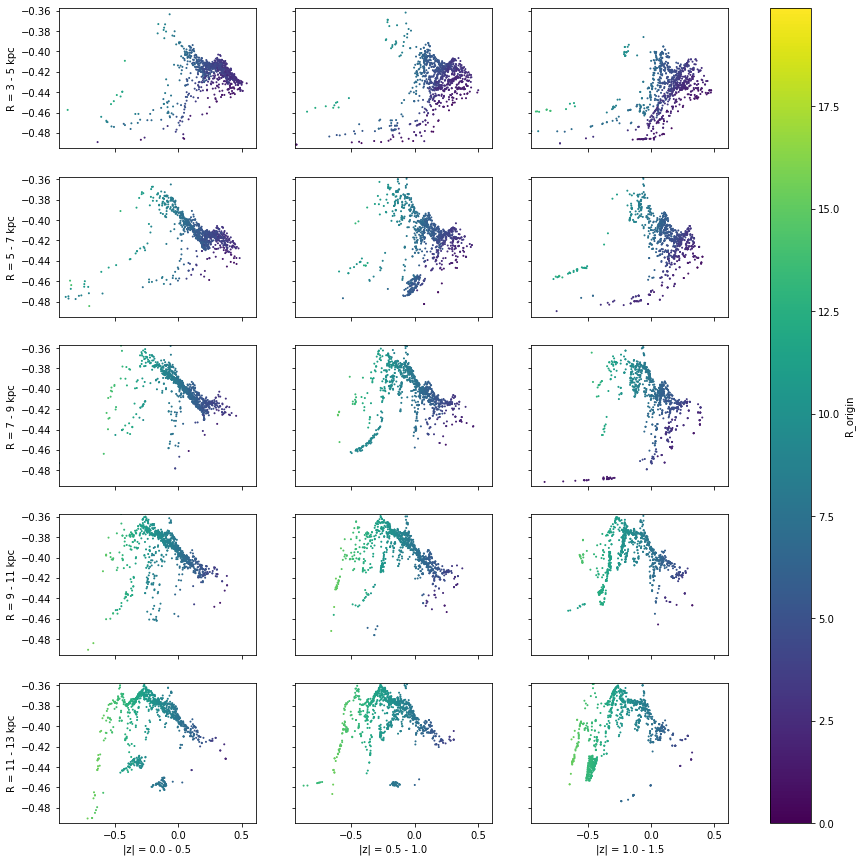

In [34]:
show_at_R_z(models["cristallo11"].stars, "[o/h]", "[c/o]", c="R_origin")
sf("cooh_R_z")


In [11]:
# not very useful

def annulus_average(output, name, zone_min, zone_max):
    return np.average(np.array([output.zones["zone%i" % i].history[name] 
                                for i in range(zone_min, zone_max)]
                              ),
                      axis=0)

def show_annulus_average(output, x, y, c=None, R_min=7, R_max=9, **kwargs):
    zone_min = R_to_zone(R_min)
    zone_max = R_to_zone(R_max)
    x_values = annulus_average(output, x, zone_min, zone_max)
    y_values = annulus_average(output, y, zone_min, zone_max)
    
    if c is None:
        plt.plot(x_values, y_values, **kwargs)
    else:
        c_values = annulus_average(output, c, zone_min, zone_max)
        plt.scatter(x_values, y_values, c=c_values, **kwargs)
        plt.colorbar()
    plt.xlabel(x)
    plt.ylabel(y)
    
def show_annulus(output, x, y, c=None, R_min=0, R_max=15.4, **kwargs):
    # modified to just show values at present_day
    zone_min = R_to_zone(R_min)
    zone_max = R_to_zone(R_max)
    x_values = [output.zones["zone%i" % i].history[x][-1] for i in range(zone_min, zone_max)]
    y_values = [output.zones["zone%i" % i].history[y][-1] for i in range(zone_min, zone_max)]
    
    if c is None:
        plt.plot(x_values, y_values, **kwargs)
    else:
        c_values = [output.zones["zone%i" % i].history[c][-1] for i in range(zone_min, zone_max)]
        plt.scatter(x_values, y_values, c=c_values, **kwargs)
        plt.colorbar()
    plt.xlabel(x)
    plt.ylabel(y)

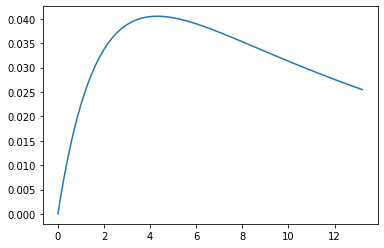

In [12]:
h = models["cristallo11"].zones["zone80"].history
plt.plot(h["time"], h["sfr"])

In [13]:
h

vice.dataframe{
    time -----------> [0, 0.01, 0.02, ... , 13.18, 13.19, 13.2]
    mgas -----------> [1e-12, 1.22571e+07, 1.84292e+07, ... , 8.44586e+07, 8.44513e+07, 8.4444e+07]
    mstar ----------> [0, 2744.13, 7980.25, ... , 2.48899e+08, 2.49037e+08, 2.49175e+08]
    sfr ------------> [0, 0.000303477, 0.000605042, ... , 0.0255281, 0.0255115, 0.0254949]
    ifr ------------> [nan, 1.22667, 0.619101, ... , 0.0677036, 0.0685492, 0.0684235]
    ofr ------------> [9.4125e-317, 0.000658962, 0.00131377, ... , 0.0554311, 0.055395, 0.0553589]
    eta_0 ----------> [2.17137, 2.17137, 2.17137, ... , 2.17137, 2.17137, 2.17137]
    r_eff ----------> [nan, 0.0957713, 0.119359, ... , 0.455493, 0.45863, 0.46095]
    z_in(fe) -------> [0, 0, 0, ... , 0, 0, 0]
    z_in(o) --------> [0, 0, 0, ... , 0, 0, 0]
    z_in(n) --------> [0, 0, 0, ... , 0, 0, 0]
    z_in(c) --------> [0, 0, 0, ... , 0, 0, 0]
    z_out(fe) ------> [0.250002, 2.96878e-07, 5.90807e-07, ... , 0.00135753, 0.00135759, 0.00135755]


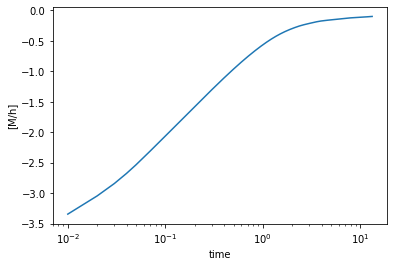

In [14]:

show_annulus_average(models["cristallo11"], "time", "[M/h]")
plt.xscale("log")

(array([1335., 1462., 1364., 1315., 1419., 1325.,  976.,  525.,  161.,
         118.]),
 array([ 0.   ,  1.312,  2.624,  3.936,  5.248,  6.56 ,  7.872,  9.184,
        10.496, 11.808, 13.12 ]),
 <BarContainer object of 10 artists>)

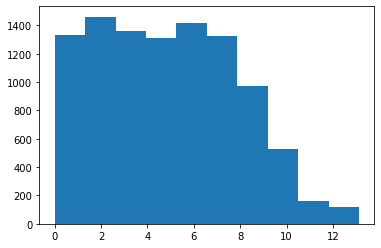

In [15]:
plt.hist(solar_neighborhood_stars["cristallo11"]["age"])

(-2.0, 0.6490987874265639)

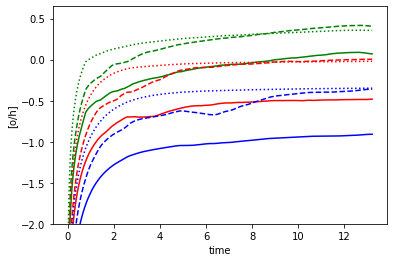

In [16]:
for i in range(3):
    ele = ["n", "fe", "o"][i]
    ls = ["-", "--", ":"][i]
    
    for j in range(3):
        R_min = [4, 8, 12][j]
        R_max = 0.1+ R_min
        c = ["green", "red", "blue"][j]
        show_annulus_average(models["cristallo11"], "time", "[%s/h]" % ele, R_min=R_min, R_max=R_max, color=c, ls=ls)
        
plt.ylim(-2)

In [17]:
def for_each_model(func, sfh="insideout"):
    names = model_names
    
    if sfh=="both":
        for name, model in models.items():
            func(model, name)
    elif sfh=="insideout":
        for name in names:
            func(models[name], name)
    else:
        for name in names:
            n = name + "_" + sfh
            func(models[n], n)

In [14]:
models["cristallo11"] = models["output/cristallo11"]

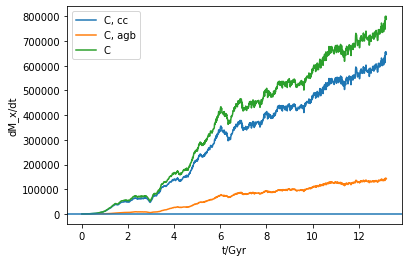

In [15]:
def agb_to_ccsn(model, name):
    agb_ratio = 0.002/0.015 #y_agb_c/y_agb_o
    h = model.zones["zone70"].history
    times = np.array(h["time"][:-1])
    eta = np.array(h["eta_0"][:-1])
    r = np.array(h["r_eff"][:-1])
    m_star = np.array(h["mstar"][:-1])
    m_o = np.array(h["mass(o)"])
    m_c = np.array(h["mass(c)"])
    z_o = np.array(h["z(o)"][:-1])
    z_c = np.array(h["z(c)"][:-1])
    dt = times[1] - times[0]
    
    d_m_o = m_o[1:] - m_o[:-1]
    d_m_c = m_c[1:] - m_c[:-1]
    
    o_cc_dot = d_m_o + (1+eta-r)*m_star * z_o
    c_cc_dot = agb_ratio * o_cc_dot
    c_agb_dot = d_m_c + (1+eta - r)*m_star * z_c - c_cc_dot
    
    plt.plot(times, c_cc_dot, label="C, cc")
    plt.plot(times, c_agb_dot, label="C, agb")
    plt.plot(times, d_m_c + (1+eta - r)*m_star * z_c, label="C")
    #plt.plot(times, do_dt, label="O")
    # plt.plot(times, o_cc_dot/0.015, label="me")
    # plt.plot(times, m_star, label="c")
    # plt.plot(h["time"], h["mgas"])

agb_to_ccsn(models["cristallo11"], "hi")
plt.legend()
plt.xlabel("t/Gyr")
plt.ylabel("dM_x/dt")
plt.axhline(0)

In [16]:
def agb_fraction(h, y_c_cc=0.002, y_o_cc=0.015):
    """
    Params
    ------
    h: singlezone history
    """
    agb_ratio = y_c_cc/y_o_cc
    
    times = np.array(h["time"][:-1])
    eta = np.array(h["eta_0"][:-1])
    r = np.array(h["r_eff"][:-1])
    m_star = np.array(h["mstar"][:-1])
    m_o = np.array(h["mass(o)"])
    m_c = np.array(h["mass(c)"])
    z_o = np.array(h["z(o)"][:-1])
    z_c = np.array(h["z(c)"][:-1])
    dt = times[1] - times[0]
    
    d_m_o = m_o[1:] - m_o[:-1]
    d_m_c = m_c[1:] - m_c[:-1]
    
    o_cc_dot = d_m_o + (1+eta-r)*m_star * z_o
    c_cc_dot = agb_ratio * o_cc_dot
    c_agb_dot = d_m_c + (1+eta - r)*m_star * z_c - c_cc_dot
    c_dot = d_m_c + (1+eta - r)*m_star * z_c
    
    return (c_agb_dot/c_dot)


In [17]:
h = models["cristallo11"].zones["zone70"].history
agb_fraction(h)

array([            nan, -1.39442595e-07,  1.33031514e-07, ...,
        1.80464383e-01,  1.80330627e-01,  1.80270635e-01])

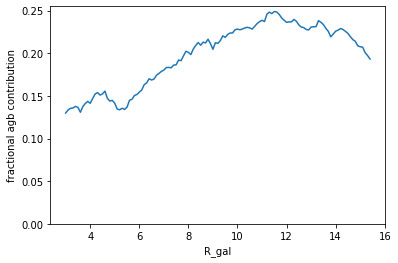

In [18]:
f = []
R = []
for i in range(30, 155):
    R.append(i/10)
    h = models["cristallo11"].zones["zone%i" % i].history
    f.append(agb_fraction(h)[-1])
    
plt.plot(R, f)
plt.xlabel("R_gal")
plt.ylabel("fractional agb contribution")
plt.ylim(0)
sf("R_f_agb")

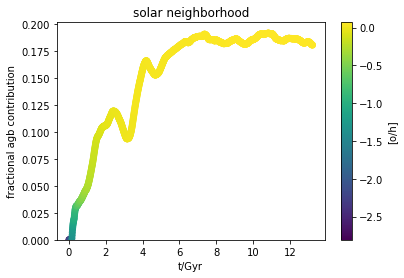

In [21]:
h = models["cristallo11"].zones["zone%i" % 70].history
plt.scatter(h["time"][1:], agb_fraction(h), c=h["[o/h]"][1:])
plt.colorbar(label="[o/h]")
plt.xlabel("t/Gyr")
plt.ylabel("fractional agb contribution")
plt.ylim(0)
plt.title("solar neighborhood")
sf("f_oh_agb")

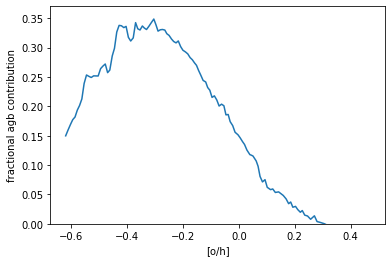

In [68]:
f = []
x = []
for i in range(30, 155):

    h = models["ventura13"].zones["zone%i" % i].history
    x.append(h["[o/h]"][-1])
    f.append(agb_fraction(h)[1000])
    
plt.plot(x, f)
plt.xlabel("[o/h]")
plt.ylabel("fractional agb contribution")
plt.ylim(0)
sf("f_oh_agb")

In [1]:
def agb_to_ccsn(model, name):
    agb_ratio = 0.002/0.015 #y_agb_c/y_agb_o
    h = model.zones["zone70"].history
    
    plt.plot(times, c_cc_dot/c_dot, label="C, cc")
    plt.plot(times, c_agb_dot/c_dot, label="C, agb")

    #plt.plot(times, do_dt, label="O")
    # plt.plot(times, o_cc_dot/0.015, label="me")
    # plt.plot(times, m_star, label="c")
    # plt.plot(h["time"], h["mgas"])

agb_to_ccsn(models["cristallo11"], "hi")
plt.legend()
plt.xlabel("t/Gyr")
plt.ylabel("AGB fractional contribution")
plt.axhline(0)
sf("f_agb_t")

NameError: name 'models' is not defined

In [9]:
def means_star_value(stars, value, bin_name, bins):
    N = len(bins) - 1
    means = np.zeros(N)
    sds = np.zeros(N)
    for i in range(N):
        filtered_stars = stars.filter(bin_name, ">=", bins[i]).filter(bin_name, "<", bins[i + 1])
        means[i] = np.mean(filtered_stars[value])
        sds[i] = np.std(filtered_stars[value])
    
    return means, sds

In [85]:
# plot c/n vs age color=fe/h
# c/n as func on fe/h should be age independent

In [ ]:
def agb_to_ccsn(model, name):
    agb_ratio = 0.002/0.015 #y_agb_c/y_agb_o
    h = model.zones["zone70"].history
    times = np.array(h["time"][:-1])
    eta = np.array(h["eta_0"][:-1])
    r = np.array(h["r_eff"][:-1])
    m_star = np.array(h["mstar"][:-1])
    m_o = np.array(h["mass(o)"])
    m_c = np.array(h["mass(c)"])
    z_o = np.array(h["z(o)"][:-1])
    z_c = np.array(h["z(c)"][:-1])
    dt = times[1] - times[0]
    
    d_m_o = m_o[1:] - m_o[:-1]
    d_m_c = m_c[1:] - m_c[:-1]
    
    o_cc_dot = d_m_o + (1+eta-r)*m_star * z_o
    c_cc_dot = agb_ratio * o_cc_dot
    c_agb_dot = d_m_c + (1+eta - r)*m_star * z_c - c_cc_dot
    
    plt.plot(times, c_cc_dot, label="C, cc")
    plt.plot(times, c_agb_dot, label="C, agb")
    plt.plot(times, d_m_c + (1+eta - r)*m_star * z_c, label="C")
    #plt.plot(times, do_dt, label="O")
    # plt.plot(times, o_cc_dot/0.015, label="me")
    # plt.plot(times, m_star, label="c")
    # plt.plot(h["time"], h["mgas"])

agb_to_ccsn(models["cristallo11"], "hi")
plt.legend()
plt.xlabel("t/Gyr")
plt.ylabel("dM_x/dt")
plt.axhline(0)